# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [152]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### First, I'll compute the camera calibration using chessboard images

In [33]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Calculate callibration img size
img = mpimg.imread(images[0])
call_img_size = img.shape
print(call_img_size)

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
        
    else:
        print('Corners not found for : {}'.format(fname))

cv2.destroyAllWindows()

(720, 1280, 3)
Corners not found for : camera_cal/calibration1.jpg
Corners not found for : camera_cal/calibration4.jpg
Corners not found for : camera_cal/calibration5.jpg


### Undistort Images

In [154]:
def undistort_img(img):
    assert (img.shape == call_img_size),'image size of {} is not compatible with callibration camera images'.format(img.shape)
    
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
    return cv2.undistort(img, mtx, dist, None, mtx)

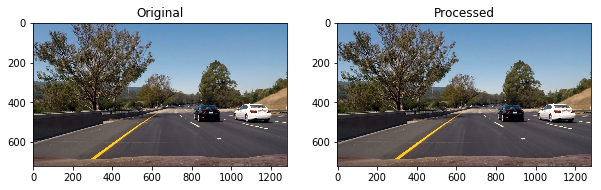

In [155]:
# TEST

test_image = mpimg.imread('test_images/test6.jpg')
und = undistort_img(test_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.set_title('Original')
ax1.imshow(test_image)
ax2.set_title('Processed')  
ax2.imshow(test_image)

### Defining various Gradients  : sobel, magnitude, direction

In [156]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):

    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

### Combining the thresholds of gradients

In [157]:
def combined_thresh(image, ksize = 3):
    # Choose a Sobel kernel size

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 110))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 110))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=(20, 100))
    dir_binary = dir_thresh(image, sobel_kernel=ksize, thresh=(0.8,1.2)) 
    combined = np.zeros_like(dir_binary, np.uint8)    
    combined[((gradx == 1) | (gradx == 1)) & ((mag_binary == 1) | (dir_binary == 1))] = 1
    return combined

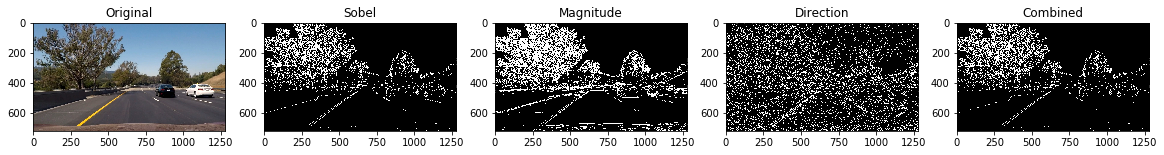

In [158]:
# TEST

sobel = abs_sobel_thresh(test_image, thresh=(20, 110))
mag = mag_thresh(test_image, thresh=(20, 100))
dire = dir_thresh(test_image, thresh=(0.8,1.2))
comb = combined_thresh(test_image)


f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,15))
ax1.set_title('Original')
ax1.imshow(org)
ax2.set_title('Sobel')  
ax2.imshow(sobel, cmap = 'gray')
ax3.set_title('Magnitude')  
ax3.imshow(mag, cmap = 'gray')
ax4.set_title('Direction')  
ax4.imshow(dire, cmap = 'gray')
ax5.set_title('Combined')  
ax5.imshow(comb, cmap = 'gray')

### Color filters and thresholding

In [159]:
def color_thresh(image):
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]

    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 255
    l_thresh_min = 190
    l_thresh_max = 255  
    
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)) ] = 1
    
    l_binary = np.zeros_like(s_channel)
    l_binary[((l_channel >= l_thresh_min) & (l_channel <= l_thresh_max))] = 1
    
    return s_binary, l_binary

### Color and Gradient thresholding combined

In [160]:
def combine_color_gradients(image):

    sxbinary = combined_thresh(image)
    s_binary, l_binary = color_thresh(image)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | ((sxbinary == 1) & (l_binary == 1))] = 1
    
    return combined_binary

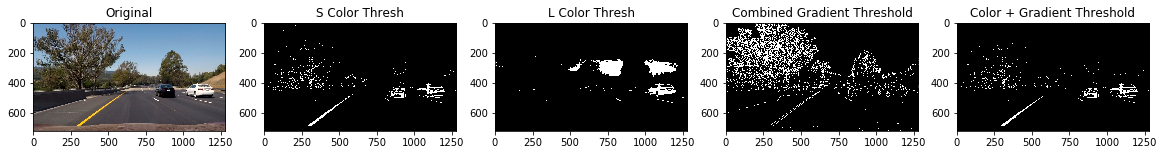

In [161]:
# TEST

s_color, l_color = color_thresh(test_image)
comb = combined_thresh(test_image)
combined_color = combine_color_gradients(test_image)


f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,15))
ax1.set_title('Original')
ax1.imshow(test_image)
ax2.set_title('S Color Thresh')  
ax2.imshow(s_color, cmap = 'gray')
ax3.set_title('L Color Thresh')  
ax3.imshow(l_color, cmap = 'gray')
ax4.set_title('Combined Gradient Threshold')  
ax4.imshow(comb, cmap = 'gray')
ax5.set_title('Color + Gradient Threshold')  
ax5.imshow(combined, cmap = 'gray')

### Warping - Perpesctive Transform and Birds Eye View

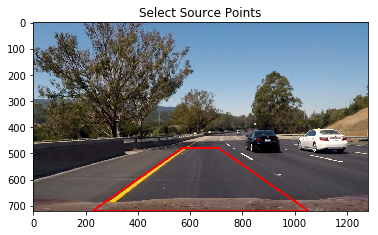

In [162]:
# Selecting and visualizing source points

x = test_image.shape[1]
y = test_image.shape[0]


src_points = np.int32([                    
                [0.177 * x, y],
                [(0.5 * x) - (x*0.055), (2/3)*y],
                [(0.5 * x) + (x*0.055), (2/3)*y],
                [x - (0.177 * x), y]
                ])

draw_poly = cv2.polylines(test_image,[src_points],True,(255,0,0), 5)
plt.title('Select Source Points')  
plt.imshow(draw_poly)

# Restore image
test_image = mpimg.imread('test_images/test6.jpg')


In [163]:
def warp(image):
    
    x = image.shape[1]
    y = image.shape[0]

    src_points = np.float32([                    
                    [0.177 * x, y],
                    [(0.5 * x) - (x*0.055), (2/3)*y],
                    [(0.5 * x) + (x*0.055), (2/3)*y],
                    [x - (0.177 * x), y]
                    ])
    
        
    dst_points = np.float32([
                    [0.25 * x, y],
                    [0.25 * x, 0],
                    [x - (0.25 * x), 0],
                    [x - (0.25 * x), y]
                    ])
    
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped


def inv_warp(image):
    
    x = image.shape[1]
    y = image.shape[0]
    
    src_points = np.float32([                    
                    [0.177 * x, y],
                    [(0.5 * x) - (x*0.055), (2/3)*y],
                    [(0.5 * x) + (x*0.055), (2/3)*y],
                    [x - (0.177 * x), y]
                    ])
    
        
    dst_points = np.float32([
                    [0.25 * x, y],
                    [0.25 * x, 0],
                    [x - (0.25 * x), 0],
                    [x - (0.25 * x), y]
                    ])
    
    M = cv2.getPerspectiveTransform(dst_points, src_points)
    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

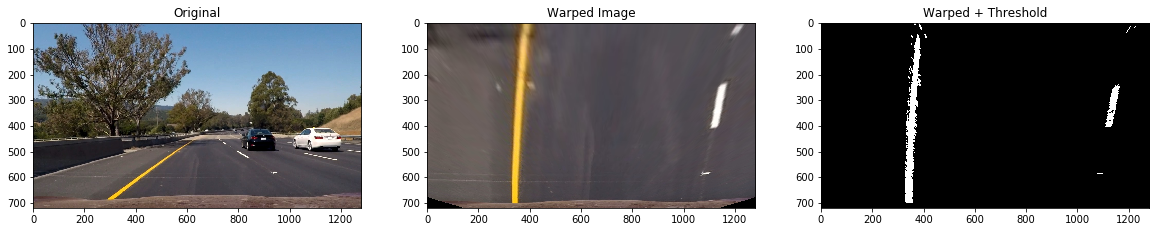

In [164]:
# TEST

comb = combine_color_gradients(test_image)
warp_img = warp(test_image)
thresh_warp_img = warp(comb)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,15))
plt.title('Warping - Perpesctive Transform and Birds Eye View')  
ax1.set_title('Original')
ax1.imshow(test_image)
ax2.set_title('Warped Image')  
ax2.imshow(warp_img, cmap = 'gray')
ax3.set_title('Warped + Threshold')  
ax3.imshow(thresh_warp_img, cmap = 'gray')

### Lane Detector

In [165]:
class LaneDetector:
    
    def __init__(self):
        self.detected = True
        self.left_lane_inds = []  # Create empty lists to receive left and right lane pixel indices
        self.right_lane_inds = []
        
        self.n_frames = 10
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = [np.zeros_like(720, np.float32), np.zeros_like(720, np.float32)]
        
        # coefficient values of the last n fits of the line
        self.recent_coefficients = []
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [0,0,0]
        
        self.vehicle_offset = 0.0
        self.avg_curverad = 1000

    def draw_lane(self, orignal_image, binary_warped, filtered_binary):    
        
        nonzero = binary_warped.nonzero()  # Identify the x and y positions of all nonzero pixels in the image
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
         
        margin = 50   
        # Set minimum number of pixels found to recenter window   
        minpix = 50
        
        if self.detected:
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            nwindows = 9  # Choose the number of sliding windows
            window_height = np.int((binary_warped.shape[0])/nwindows)   # Set height of windows

            leftx_current = leftx_base   # Current positions to be updated for each window
            rightx_current = rightx_base   # Set the width of the windows +/- margin
            
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):

                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                                  (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                                   (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            self.left_lane_inds = np.concatenate(left_lane_inds)
            self.right_lane_inds = np.concatenate(right_lane_inds)
        else:
            self.left_lane_inds = ((nonzerox > (self.best_fit[0][0]*(nonzeroy**2) + self.best_fit[0][1]*nonzeroy + 
                                    self.best_fit[0][2] - margin)) & (nonzerox < (self.best_fit[0][0]*(nonzeroy**2) + 
                                    self.best_fit[0][1]*nonzeroy + self.best_fit[0][2] + margin))) 
            self.right_lane_inds = ((nonzerox > (self.best_fit[1][0]*(nonzeroy**2) + self.best_fit[1][1]*nonzeroy + 
                                    self.best_fit[1][2] - margin)) & (nonzerox < (self.best_fit[1][0]*(nonzeroy**2) + 
                                    self.best_fit[1][1]*nonzeroy + self.best_fit[1][2] + margin)))
        
        
        # Again, extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        # Fit a second order polynomial to each
        if lefty.shape[0] >= 400 and righty.shape[0] >= 400 and leftx.shape[0] >= 400 and rightx.shape[0] >= 400:
            self.detected = False
            self.left_fit = np.polyfit(lefty, leftx, 2)
            self.right_fit = np.polyfit(righty, rightx, 2)
            
            
            if len(self.recent_coefficients) >= self.n_frames:
                self.recent_coefficients.pop(0)
            self.recent_coefficients.append([self.left_fit, self.right_fit])

            self.best_fit = [0,0,0]
            for coefficient in self.recent_coefficients:
                self.best_fit[0] = self.best_fit[0] + coefficient[0]
                self.best_fit[1] = self.best_fit[1] + coefficient[1]

            self.best_fit[0] = self.best_fit[0]/len(self.recent_coefficients)
            self.best_fit[1] = self.best_fit[1]/len(self.recent_coefficients)


            # Generate x and y values for plotting
            left_fitx = self.best_fit[0][0]*ploty**2 + self.best_fit[0][1]*ploty + self.best_fit[0][2]
            right_fitx = self.best_fit[1][0]*ploty**2 + self.best_fit[1][1]*ploty + self.best_fit[1][2]

            if len(self.recent_xfitted) >= self.n_frames:
                self.recent_xfitted.pop(0)


            self.recent_xfitted.append([left_fitx, right_fitx])


            self.bestx = [np.zeros_like(720, np.float32), np.zeros_like(720, np.float32)]
            for fit in self.recent_xfitted:
                self.bestx[0] = self.bestx[0] + fit[0]
                self.bestx[1] = self.bestx[1] + fit[1]

            self.bestx[0] = self.bestx[0]/len(self.recent_xfitted)
            self.bestx[1] = self.bestx[1]/len(self.recent_xfitted)
                     
            
        else:
            self.detected = True
        
        
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[self.right_lane_inds], nonzerox[self.right_lane_inds]] = [0, 0, 255]
        

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = 5
        left_line_window1 = np.array([np.transpose(np.vstack([self.bestx[0]-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.bestx[0]+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))

        right_line_window1 = np.array([np.transpose(np.vstack([self.bestx[1]-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.bestx[1]+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))


        center_line_window1 = np.array([np.transpose(np.vstack([self.bestx[0]+margin, ploty]))])
        center_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.bestx[1]-margin, ploty])))])
        center_line_pts = np.hstack((center_line_window1,center_line_window2))


        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,0, 0))
        cv2.fillPoly(window_img, np.int_([center_line_pts]), (0,255, 0))

        window_img_unwrapped = inv_warp(window_img)

        result = cv2.addWeighted(orignal_image, 1, window_img_unwrapped, 0.3, 0)
        
        
        if leftx.shape[0] >= ploty.shape[0] and rightx.shape[0] >= ploty.shape[0] :
            leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
            rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

            # Define conversions in x and y from pixels space to meters
            ym_per_pix = 4.3/binary_warped.shape[0] # meters per pixel in y dimension
            xm_per_pix = 1/binary_warped.shape[1] # meters per pixel in x dimension

            self.vehicle_offset = ((binary_warped.shape[1]/2) - (((rightx[0] - leftx[0])/2) + leftx[0]))*xm_per_pix
            

            leftx = leftx[:len(ploty)]
            rightx = rightx[:len(ploty)]

            y_eval = np.max(ploty)
            
            # Fit new polynomials to x,y in world space
            left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
            right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
            # Calculate the new radii of curvature
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
            # Now our radius of curvature is in meters
            self.avg_curverad = (left_curverad + right_curverad) / 2
            
        cv2.putText(result, 'Vehicle is ' + str(-self.vehicle_offset)[0:5] + 'm left of center', (30,140), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)
        cv2.putText(result, 'Radius of Curvature = ' + str(int(np.round(self.avg_curverad))) + '(m)', (30,80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)
        
        
        return result

In [166]:
lane_detector = LaneDetector()
draw_lane = lane_detector.draw_lane

In [167]:
def process_image(image):
    undistorted = undistort_img(image)
    filtered_binary = combine_color_gradients(undistorted)
    binary_warped = warp(filtered_binary)
    final_image = draw_lane(image, binary_warped, filtered_binary)
    return final_image

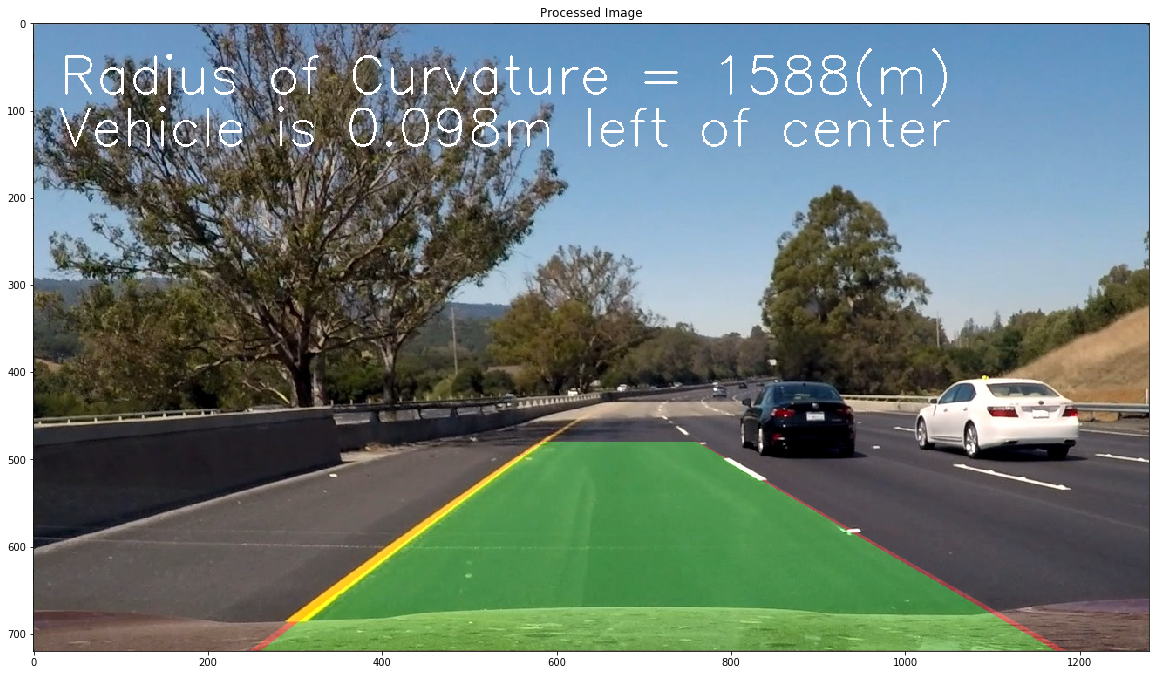

In [168]:
# TEST

res = process_image(test_image)
plt.figure(figsize=(20,20))
plt.title('Processed Image')  
plt.imshow(res, cmap = 'gray')

### Testing on videos

In [169]:
lane_detector = LaneDetector()
draw_lane = lane_detector.draw_lane
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



  2%|▏         | 30/1261 [00:28<19:27,  1.05it/s]


KeyboardInterrupt: 

In [ ]:
lane_detector = LaneDetector()
draw_lane = lane_detector.draw_lane
white_output = 'challenge_video_out.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
lane_detector = LaneDetector()
draw_lane = lane_detector.draw_lane
white_output = 'harder_challenge_video_out.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)